In [1]:
%matplotlib inline
import pandas as pd
import uproot
import awkward
import matplotlib.pyplot as plt
import numpy as np
import glob
from matplotlib.colors import LogNorm
import uproot_methods
from tqdm.auto import tqdm
import time

from utils import set_plotting_style, get_chunking, get_chunking_dask, make_df_dask, hist2d_dask, query_dis
import utils

from dask.distributed import Client
import dask.dataframe as dd
import dask.array as da
from dask import delayed
from yahist import Hist1D, Hist2D

In [2]:
set_plotting_style()

In [4]:
client = Client("tcp://169.228.130.74:3223")
client

Client Scheduler: tcp://169.228.130.74:3223 Dashboard: http://169.228.130.74:13345/status,Cluster Workers: 22 Cores: 22 Memory: 88.00 GB


In [8]:
fnames = glob.glob("/hadoop/cms/store/user/namin/ProjectMetis/ScoutingCaloMuon_Run2018skim_2018C_v9_unblind1fb_RAW_v10/*.root")
# fnames = fnames[:5]

branches = ["dimuon_mass", "pass_*","logabsetaphi","DV_rhoCorr","DV_x","DV_y"]
# cut = "pass_baseline_iso"
cut = "pass_skim"
# cut = "pass_baseline"

ddf = make_df_dask(
    fnames,
    branches = branches,
    cut = cut,
    chunksize = 1e6,
    persist = True,
)

In [9]:
# ddf = ddf.repartition(partition_size="100MB").persist()

In [10]:
# del ddf
ddf

,dimuon_mass,pass_skim,pass_l1,pass_fiducialgen,pass_fiducialgen_norho,pass_baseline,pass_baseline_iso,logabsetaphi,DV_rhoCorr,DV_x,DV_y
npartitions=28,,,,,,,,,,,
,float32,bool,bool,bool,bool,bool,bool,float32,float32,float32,float32
,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...


64293529
CPU times: user 504 ms, sys: 12 ms, total: 516 ms
Wall time: 1.09 s


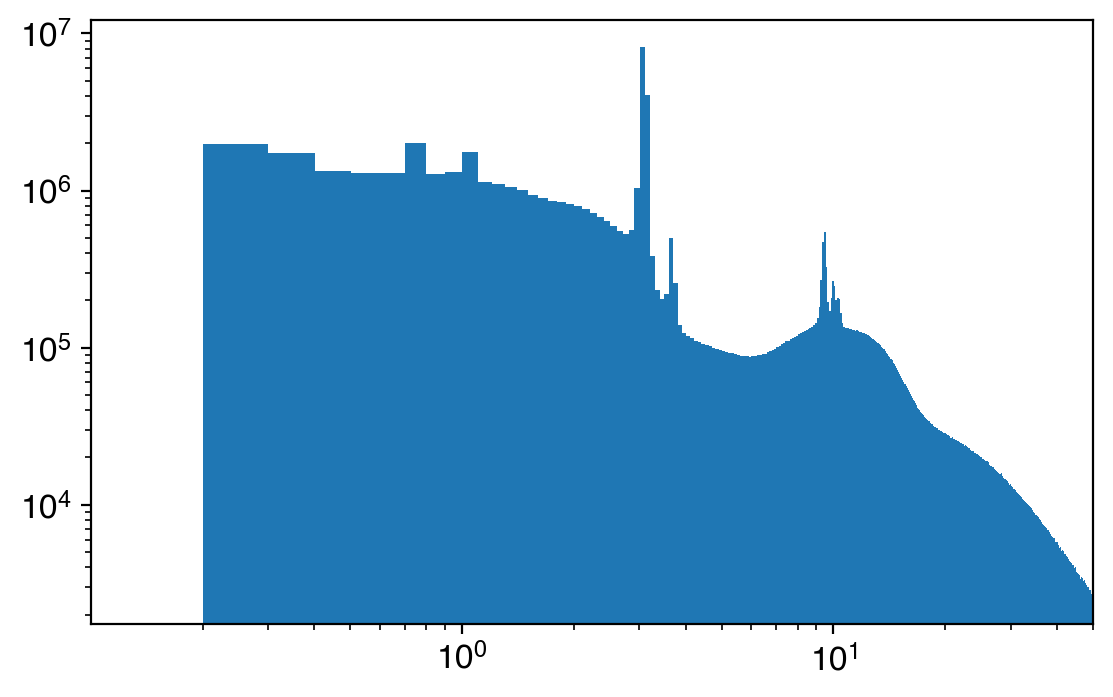

In [12]:
%%time
bins = np.linspace(0,50,500)
counts = da.histogram(da.clip(ddf["dimuon_mass"],bins[0],bins[-1]), bins=bins)[0].compute()
print(counts.sum())
h = Hist1D.from_bincounts(counts, bins, errors=counts**0.5)
h.plot()
plt.gca().set_yscale("log")
plt.gca().set_xscale("log")

In [13]:
# ddf.query("pass_baseline_iso>0")
ddf

,dimuon_mass,pass_skim,pass_l1,pass_fiducialgen,pass_fiducialgen_norho,pass_baseline,pass_baseline_iso,logabsetaphi,DV_rhoCorr,DV_x,DV_y
npartitions=28,,,,,,,,,,,
,float32,bool,bool,bool,bool,bool,bool,float32,float32,float32,float32
,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...


In [17]:
def get_hist(df, varexp, sel="dimuon_mass>0", bins=np.linspace(0,10,100)):
#     t0 = time.time()
    if sel:
        df = df.query(sel)
    counts = da.histogram(
        da.clip(
            df.eval(varexp),
            bins[0],
            bins[-1]
        ), bins=bins
    )[0].compute()
#     t1 = time.time()
#     print(f"{counts.sum()} events in {t1-t0:.2f}s @ {counts.sum()/(t1-t0)*1e-6:.2f}MHz")
    print(f"{counts.sum()} events")
    h = Hist1D.from_bincounts(counts, bins, errors=counts**0.5)
    return h

197 events
CPU times: user 225 ms, sys: 8 ms, total: 233 ms
Wall time: 14 s


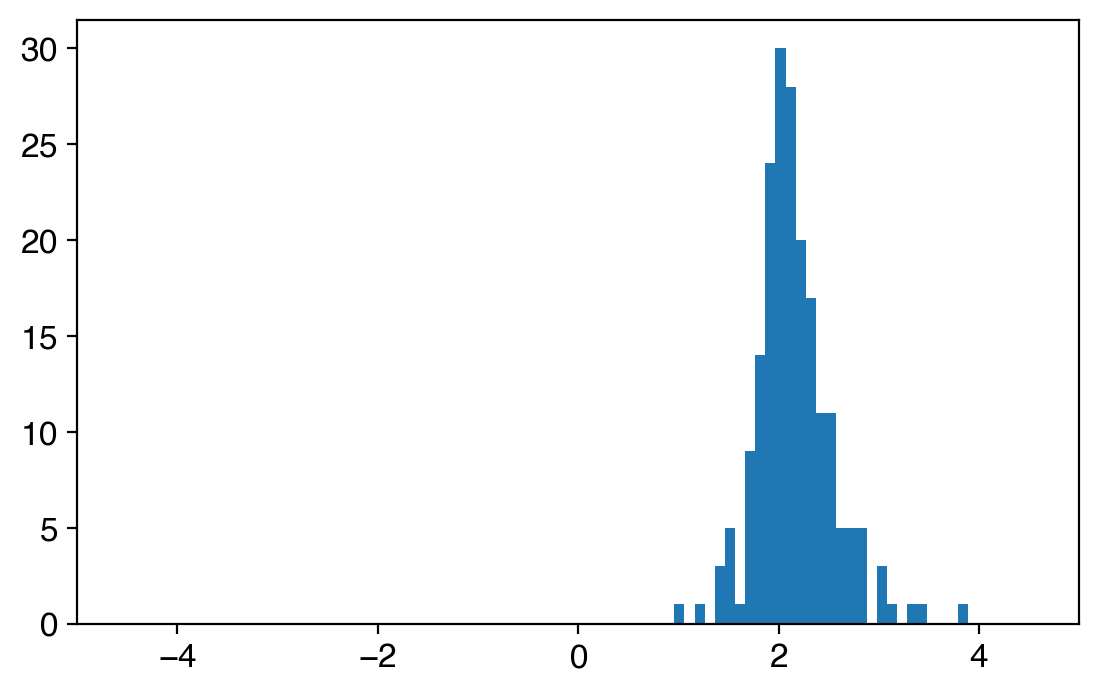

In [18]:
%%time
# get_hist(ddf, "logabsetaphi", sel="pass_baseline_iso and DV_rhoCorr>2.5", bins=np.linspace(-5,5,100)).plot()
# get_hist(ddf, "logabsetaphi", bins=np.linspace(-5,5,100)).plot()
get_hist(ddf, "logabsetaphi", sel="pass_baseline_iso and dimuon_mass>5 and DV_rhoCorr>2.5", bins=np.linspace(-5,5,100)).plot()

In [19]:
1e-6*ddf.memory_usage().sum().compute()

2185.979986

In [20]:
bins = [np.linspace(-15,15,200),np.linspace(-15,15,200)]
counts = hist2d_dask(ddf.query("pass_baseline_iso"), x="DV_x", y="DV_y", bins=bins).compute()
h = Hist2D.from_bincounts(counts, bins, errors=counts**0.5)

(<matplotlib.image.AxesImage at 0x7fee0db2e400>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fee0c4b7470>)

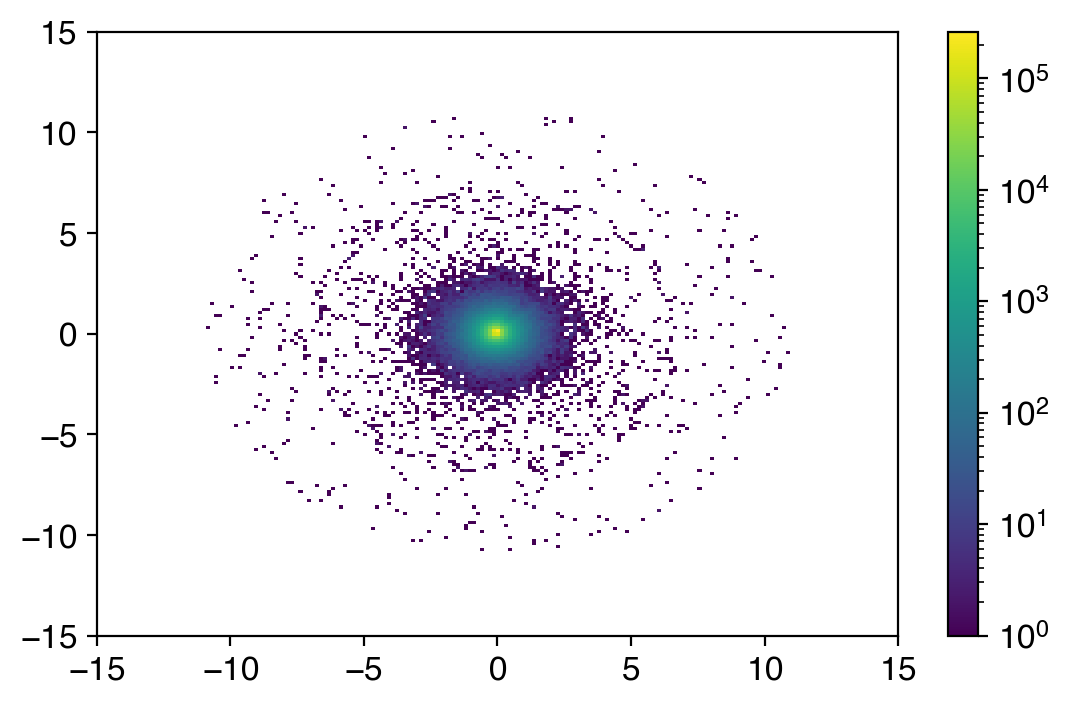

In [21]:
h.plot(logz=True)